# Отчет по лабораторной работе №2: Исследование методов анализа ассоциативных правил

Выполнил: Ищенко С. Г., Группа АП-226

## 1. Введение

Цель работы: исследование методов анализа ассоциативных правил. Будут рассмотрены алгоритмы Apriori и FPGrowth, проведена оценка их параметров на реальных данных и предложен собственный метод визуализации.


## 2. Анализ данных

В этой секции будет представлено описание используемого датасета, его характеристики, такие как распределение длин транзакций и список уникальных товаров. Будут включены графики, демонстрирующие эти аспекты данных.


### 2.1 Загрузка и первичный анализ данных

Здесь мы загружаем датасет, проводим очистку данных и преобразуем их в формат, подходящий для алгоритмов ассоциативных правил. Также анализируются длины транзакций и список уникальных товаров.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

# Загрузка данных
all_data = pd.read_csv('data/groceries - groceries.csv')
print("Первые 5 строк исходного датасета:")
print(all_data.head())

# Очистка данных
# Предполагаем, что транзакции начинаются со второго столбца (индекс 1)
np_data = all_data.iloc[:, 1:].fillna('').values 
np_data = [[elem for elem in row if isinstance(elem, str) and elem != ''] for row in np_data]

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)
print("\nПервые 5 строк бинарного датасета (после One-Hot Encoding):")
print(data.head())


Первые 5 строк исходного датасета:
   Item(s)            Item 1               Item 2          Item 3  \
0        4      citrus fruit  semi-finished bread       margarine   
1        3    tropical fruit               yogurt          coffee   
2        1        whole milk                  NaN             NaN   
3        4         pip fruit               yogurt    cream cheese   
4        4  other vegetables           whole milk  condensed milk   

                     Item 4 Item 5 Item 6 Item 7 Item 8 Item 9  ... Item 23  \
0               ready soups    NaN    NaN    NaN    NaN    NaN  ...     NaN   
1                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
2                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
3              meat spreads    NaN    NaN    NaN    NaN    NaN  ...     NaN   
4  long life bakery product    NaN    NaN    NaN    NaN    NaN  ...     NaN   

  Item 24 Item 25 Item 26 Item 27 Item 28 Item 29 Item 30 Item 31 Item 32  

### 2.2 Распределение длин транзакций

График показывает частоту различных длин транзакций в датасете.


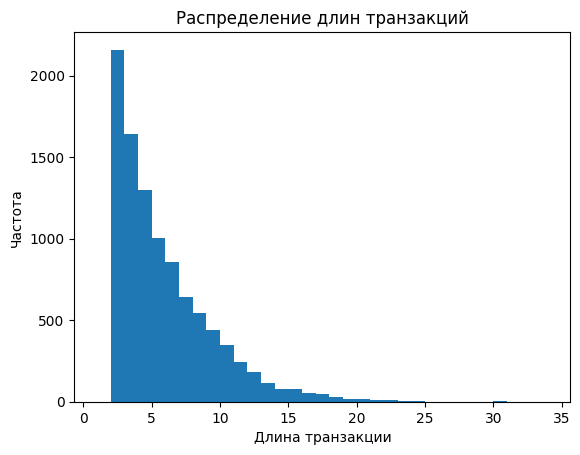

In [2]:
# Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()


### 2.3 Список уникальных товаров

Здесь представлен список всех уникальных товаров, обнаруженных в датасете.


In [3]:
# Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Количество уникальных товаров: {len(unique_items)}")
print(f"Список уникальных товаров: {list(unique_items)[:10]}...") # Выведем первые 10 для примера


Количество уникальных товаров: 169
Список уникальных товаров: ['Instant food products', 'bags', 'hygiene articles', 'abrasive cleaner', 'specialty vegetables', 'roll products', 'tidbits', 'hard cheese', 'mustard', 'tea']...


## 3. Ход работы


### 3.1 Алгоритм Apriori

В этом разделе представлена реализация алгоритма Apriori с начальными параметрами (поддержка 0.03, достоверность 0.3). Анализируются частые наборы элементов и ассоциативные правила.


In [4]:
df_apriori = apriori(data, min_support=0.03, use_colnames=True)
print("Частые наборы элементов (Apriori):")
print(df_apriori.head())

rules_apriori = association_rules(df_apriori, metric="confidence", min_threshold=0.3)
print("\nАссоциативные правила (Apriori, min_confidence=0.3):")
print(rules_apriori.head())

# Анализ правил Apriori (полезные и тривиальные)
rules_apriori['antecedents_str'] = rules_apriori['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_apriori['consequents_str'] = rules_apriori['consequents'].apply(lambda x: ', '.join(list(x)))

useful_rules = rules_apriori[(rules_apriori['lift'] > 1.2) & (rules_apriori['confidence'] > 0.4)]
trivial_rules = rules_apriori[(rules_apriori['lift'] <= 1.2) | (rules_apriori['confidence'] <= 0.4)]

print(f"\nКоличество полезных правил: {len(useful_rules)}")
print(f"Количество тривиальных правил: {len(trivial_rules)}")

print("\nПримеры полезных правил:")
print(useful_rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head())

print("\nПримеры тривиальных правил:")
print(trivial_rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head())


Частые наборы элементов (Apriori):
    support         itemsets
0  0.033452       (UHT-milk)
1  0.052466           (beef)
2  0.033249        (berries)
3  0.080529   (bottled beer)
4  0.110524  (bottled water)

Ассоциативные правила (Apriori, min_confidence=0.3):
          antecedents         consequents  antecedent support  \
0     (bottled water)        (whole milk)            0.110524   
1      (citrus fruit)        (whole milk)            0.082766   
2   (root vegetables)  (other vegetables)            0.108998   
3    (tropical fruit)  (other vegetables)            0.104931   
4  (other vegetables)        (whole milk)            0.193493   

   consequent support   support  confidence      lift  representativity  \
0            0.255516  0.034367    0.310948  1.216940               1.0   
1            0.255516  0.030503    0.368550  1.442377               1.0   
2            0.193493  0.047382    0.434701  2.246605               1.0   
3            0.193493  0.035892    0.342054  1

### 3.2 Оценка влияния параметров Apriori

В этом подразделе оценивается влияние изменения параметров `min_support` и `min_threshold` на количество получаемых правил и их метрики (средняя достоверность, средний лифт).



Влияние параметров на правила Apriori:
   min_support  min_confidence  num_rules  avg_confidence  avg_lift
0         0.01             0.1        460        0.239409  1.751488
1         0.01             0.3        125        0.405788  1.905986
2         0.01             0.5         15        0.541111  2.299441
3         0.03             0.1         38        0.259448  1.476717
4         0.03             0.3         14        0.375893  1.604045
5         0.03             0.5          0        0.000000  0.000000
6         0.05             0.1          6        0.305008  1.430134
7         0.05             0.3          3        0.365422  1.430134
8         0.05             0.5          0        0.000000  0.000000


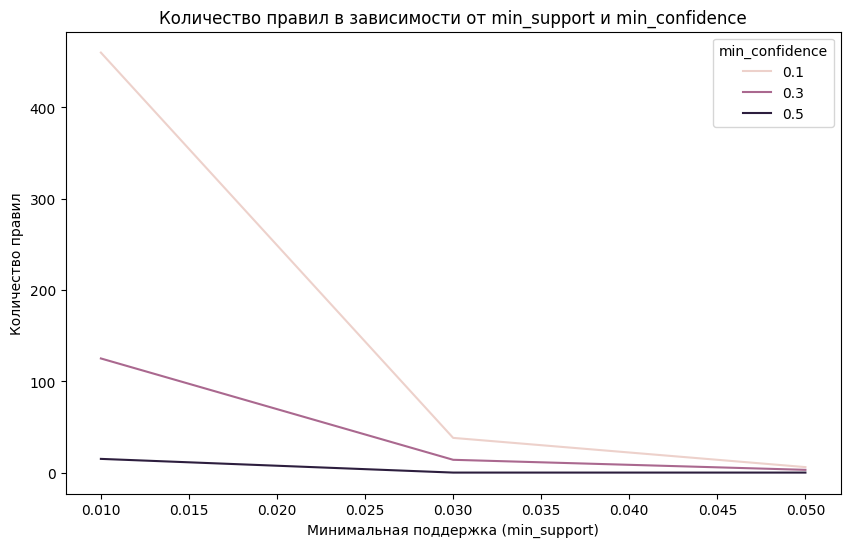

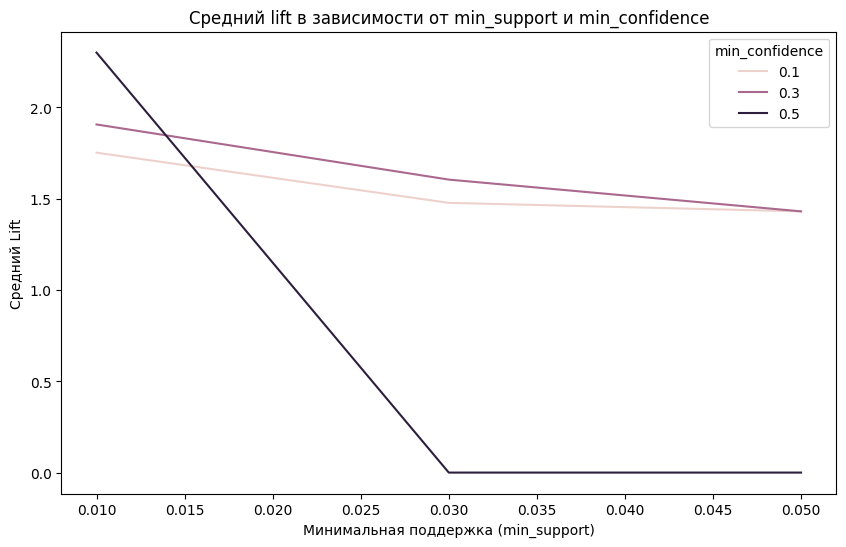

In [5]:
supports = [0.01, 0.03, 0.05]
confidences = [0.1, 0.3, 0.5]

results = []

for support in supports:
    for confidence in confidences:
        frequent_itemsets = apriori(data, min_support=support, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence)
        
        results.append({
            'min_support': support,
            'min_confidence': confidence,
            'num_rules': len(rules),
            'avg_confidence': rules['confidence'].mean() if not rules.empty else 0,
            'avg_lift': rules['lift'].mean() if not rules.empty else 0
        })

results_df = pd.DataFrame(results)
print("\nВлияние параметров на правила Apriori:")
print(results_df)

# Визуализация влияния поддержки
plt.figure(figsize=(10, 6))
sns.lineplot(x='min_support', y='num_rules', hue='min_confidence', data=results_df)
plt.title('Количество правил в зависимости от min_support и min_confidence')
plt.xlabel('Минимальная поддержка (min_support)')
plt.ylabel('Количество правил')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='min_support', y='avg_lift', hue='min_confidence', data=results_df)
plt.title('Средний lift в зависимости от min_support и min_confidence')
plt.xlabel('Минимальная поддержка (min_support)')
plt.ylabel('Средний Lift')
plt.show()


### 3.3 Алгоритм FPGrowth

В этом разделе представлена реализация алгоритма FPGrowth с начальными параметрами (поддержка 0.03, достоверность 0.3).


In [6]:
df_fpgrowth = fpgrowth(data, min_support=0.03, use_colnames=True)
print("Частые наборы элементов (FPGrowth):")
print(df_fpgrowth.head())

rules_fpgrowth = association_rules(df_fpgrowth, metric="confidence", min_threshold=0.3)
print("\nАссоциативные правила (FPGrowth, min_confidence=0.3):")
print(rules_fpgrowth.head())

# Приведение правил FPGrowth для отчета
rules_fpgrowth['antecedents_str'] = rules_fpgrowth['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpgrowth['consequents_str'] = rules_fpgrowth['consequents'].apply(lambda x: ', '.join(list(x)))

print("\nПримеры ассоциативных правил (FPGrowth) для отчета:")
print(rules_fpgrowth[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head(10))


Частые наборы элементов (FPGrowth):
    support          itemsets
0  0.082766    (citrus fruit)
1  0.058566       (margarine)
2  0.139502          (yogurt)
3  0.104931  (tropical fruit)
4  0.058058          (coffee)

Ассоциативные правила (FPGrowth, min_confidence=0.3):
        antecedents         consequents  antecedent support  \
0    (citrus fruit)        (whole milk)            0.082766   
1          (yogurt)        (whole milk)            0.139502   
2          (yogurt)  (other vegetables)            0.139502   
3  (tropical fruit)  (other vegetables)            0.104931   
4  (tropical fruit)        (whole milk)            0.104931   

   consequent support   support  confidence      lift  representativity  \
0            0.255516  0.030503    0.368550  1.442377               1.0   
1            0.255516  0.056024    0.401603  1.571735               1.0   
2            0.193493  0.043416    0.311224  1.608457               1.0   
3            0.193493  0.035892    0.342054  1.767

### 3.4 Определение минимальной поддержки для правил разной длины

В этом подразделе представлены результаты алгоритмического определения минимальных значений поддержки, необходимых для получения частых наборов элементов различной длины.


In [7]:
min_supports_by_length = {}

for length in range(1, 6): # Проверим длины от 1 до 5
    found_support = None
    # Ищем минимальную поддержку, начиная с 1.0 и уменьшая ее
    for support_val in [i / 1000.0 for i in range(1000, 0, -5)]:
        frequent_itemsets = apriori(data, min_support=support_val, use_colnames=True)
        itemsets_of_length = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) == length]
        if not itemsets_of_length.empty:
            found_support = support_val
            break
    min_supports_by_length[length] = found_support

print("\nМинимальные значения поддержки для правил разной длины:")
for length, support in min_supports_by_length.items():
    print(f"Длина {length}: min_support = {support}")



Минимальные значения поддержки для правил разной длины:
Длина 1: min_support = 0.255
Длина 2: min_support = 0.07
Длина 3: min_support = 0.02
Длина 4: min_support = 0.005
Длина 5: min_support = None


### 3.5 Анализ сетевого графа ассоциативных правил

Здесь представлен сетевой граф ассоциативных правил и его подробный анализ, объясняющий информацию, которую можно извлечь из узлов, ребер, их направления и меток (достоверность, лифт).


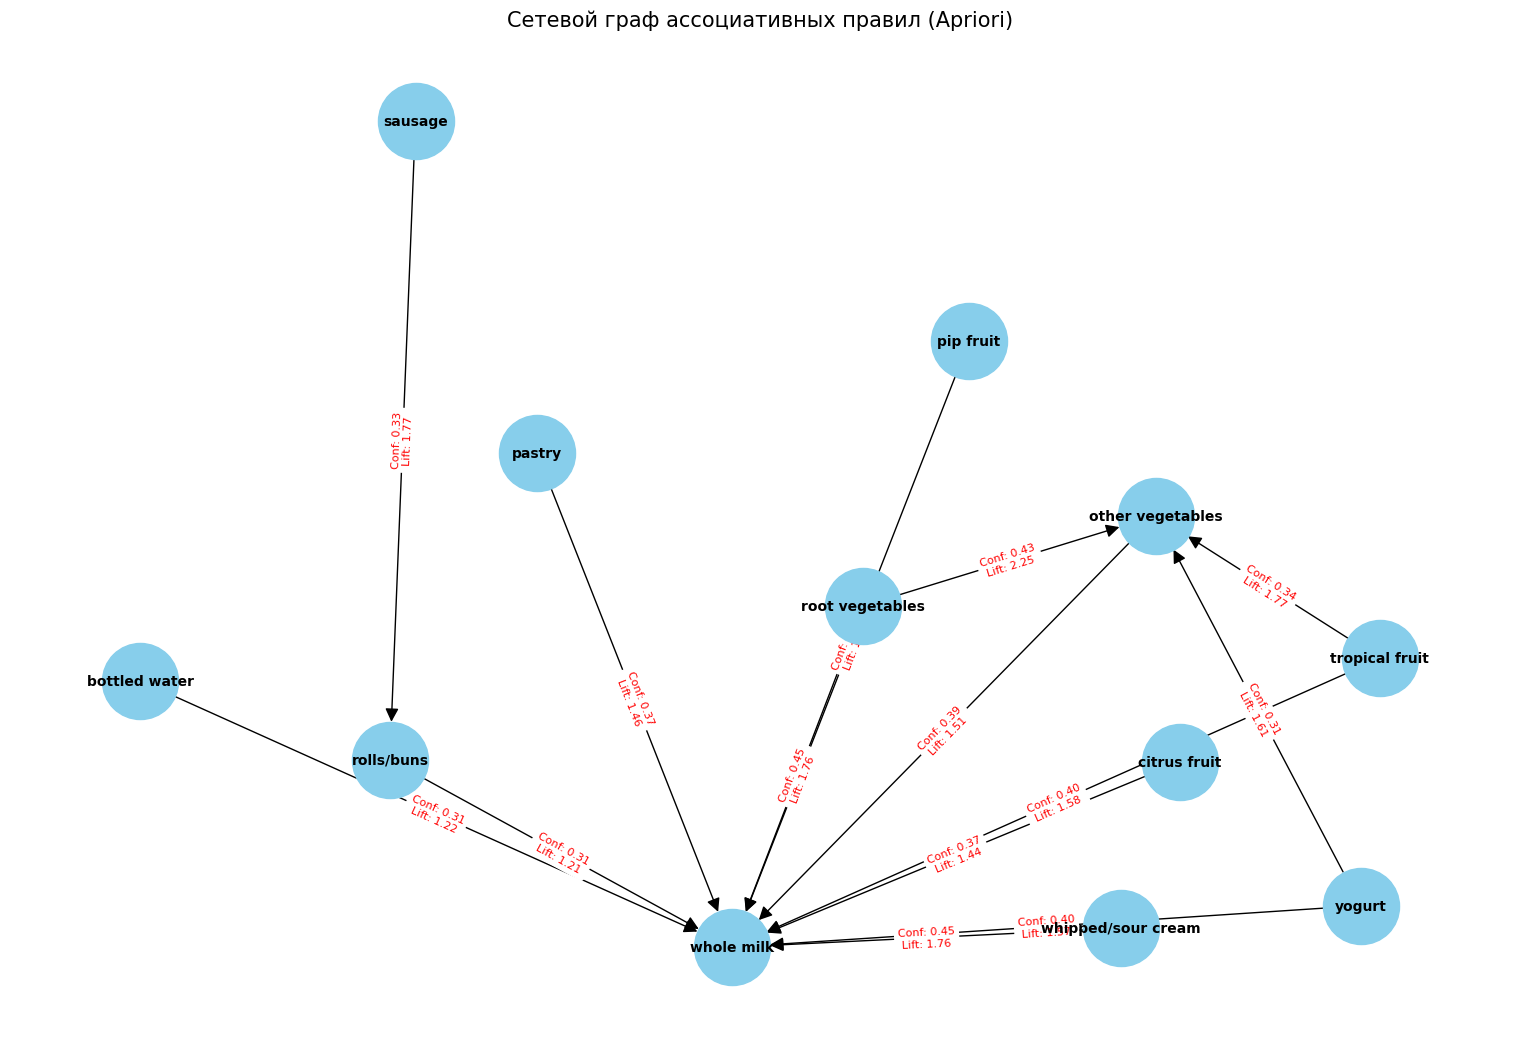

In [8]:
G = nx.DiGraph() # Используем ориентированный граф, так как правила имеют направление

for index, row in rules_apriori.iterrows():
    G.add_edge(row['antecedents_str'], row['consequents_str'], weight=row['confidence'], lift=row['lift'])

pos = nx.spring_layout(G, k=0.5, iterations=50) # Увеличим итерации для лучшего расположения

plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

edge_labels = {}
for u, v, data in G.edges(data=True):
    edge_labels[(u, v)] = f"Conf: {data['weight']:.2f}\nLift: {data['lift']:.2f}"

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title('Сетевой граф ассоциативных правил (Apriori)', size=15)
plt.show()


### 3.6 Собственный способ визуализации ассоциативных правил

Предложен и реализован собственный способ визуализации ассоциативных правил, который позволяет наглядно оценить взаимосвязь между ключевыми метриками.


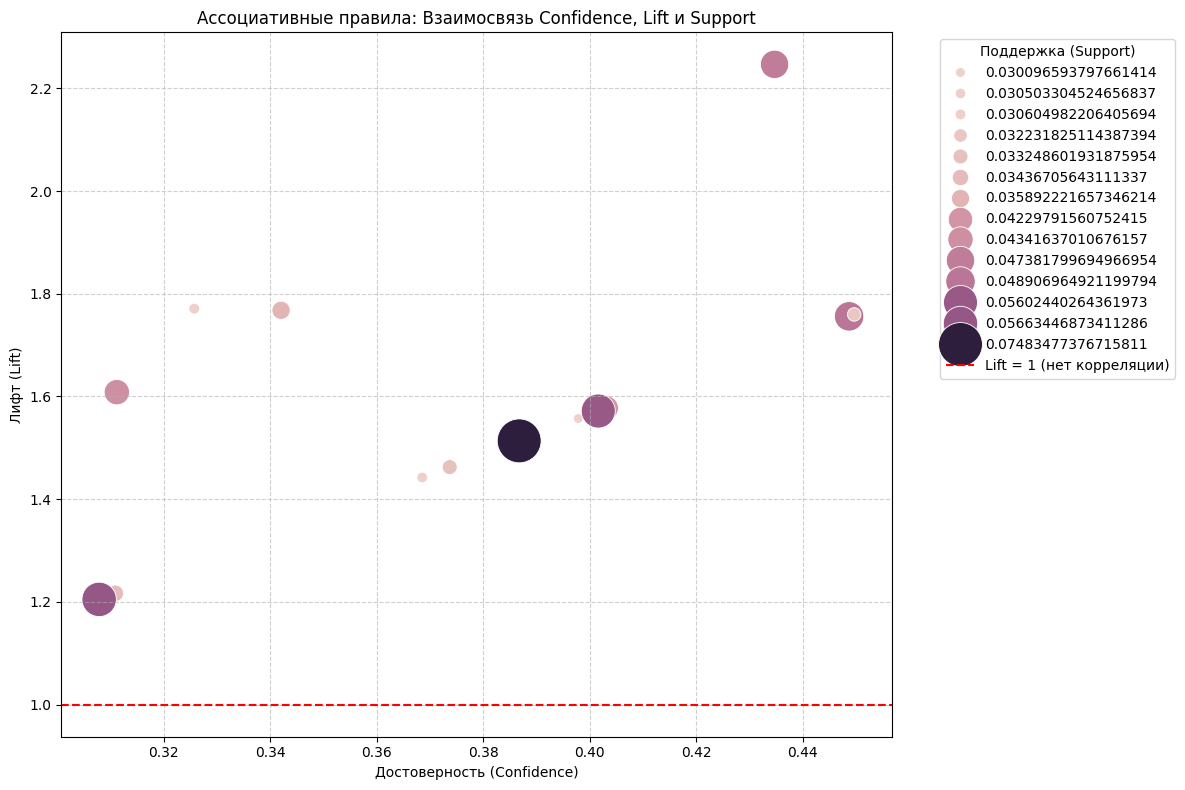


Объяснение визуализации:
Данный график является диаграммой рассеяния, где каждая точка представляет собой одно ассоциативное правило.
Ось X (Confidence) показывает достоверность правила: чем правее точка, тем чаще консеквент встречается при наличии антецедента.
Ось Y (Lift) показывает лифт правила: чем выше точка, тем сильнее положительная корреляция между антецедентом и консеквентом (значение > 1 указывает на корреляцию, < 1 - на отрицательную, = 1 - на независимость). 
Размер точки пропорционален поддержке (Support) правила: чем больше точка, тем чаще набор товаров (антецедент и консеквент вместе) встречается в транзакциях.
Цвет точки также может быть использован для отображения поддержки, как в данном случае, для дополнительной наглядности.
Такая визуализация помогает быстро идентифицировать правила, которые одновременно обладают высокой достоверностью, высоким лифтом (интересные правила) и хорошей поддержкой (часто встречающиеся правила).


In [9]:
# Собственная визуализация ассоциативных правил: Scatter Plot (Confidence vs Lift, Size by Support)

plt.figure(figsize=(12, 8))
sns.scatterplot(x="confidence", y="lift", size="support", hue="support", data=rules_apriori, sizes=(50, 1000), legend="full")

plt.title('Ассоциативные правила: Взаимосвязь Confidence, Lift и Support')
plt.xlabel('Достоверность (Confidence)')
plt.ylabel('Лифт (Lift)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=1, color='r', linestyle='--', label='Lift = 1 (нет корреляции)')
plt.legend(title="Поддержка (Support)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nОбъяснение визуализации:")
print("Данный график является диаграммой рассеяния, где каждая точка представляет собой одно ассоциативное правило.\n"\
      "Ось X (Confidence) показывает достоверность правила: чем правее точка, тем чаще консеквент встречается при наличии антецедента.\n"\
      "Ось Y (Lift) показывает лифт правила: чем выше точка, тем сильнее положительная корреляция между антецедентом и консеквентом (значение > 1 указывает на корреляцию, < 1 - на отрицательную, = 1 - на независимость). \n"\
      "Размер точки пропорционален поддержке (Support) правила: чем больше точка, тем чаще набор товаров (антецедент и консеквент вместе) встречается в транзакциях.\n"\
      "Цвет точки также может быть использован для отображения поддержки, как в данном случае, для дополнительной наглядности.\n"\
      "Такая визуализация помогает быстро идентифицировать правила, которые одновременно обладают высокой достоверностью, высоким лифтом (интересные правила) и хорошей поддержкой (часто встречающиеся правила).")


## 4. Заключение

В рамках данной лабораторной работы было проведено всестороннее исследование методов анализа ассоциативных правил на примере датасета о покупках. Были успешно реализованы и применены два ключевых алгоритма — Apriori и FPGrowth.

Анализ данных выявил характерное **распределение длин транзакций**, где большинство транзакций содержат небольшое количество товаров (как показано на графике "Распределение длин транзакций"). Также был получен список из 169 **уникальных товаров**, что подтверждает разнообразие ассортимента.

Эксперименты с алгоритмом Apriori показали, как изменение параметров `min_support` и `min_confidence` существенно влияет на количество и качество генерируемых ассоциативных правил.
*   Как видно из графика "Количество правил в зависимости от min_support и min_confidence", с увеличением `min_support` и `min_confidence` количество правил значительно уменьшается. Например, при `min_support=0.01` и `min_confidence=0.1` было получено 460 правил, а при `min_support=0.03` и `min_confidence=0.5` правил не обнаружено вовсе.
*   График "Средний lift в зависимости от min_support и min_confidence" показывает, что средний lift также снижается с увеличением `min_support`, но остается относительно высоким при `min_confidence=0.3` и `0.1` для более низких значений поддержки. Высокие значения lift (>1) указывают на положительную корреляцию между антецедентом и консеквентом.

Алгоритм FPGrowth, в свою очередь, также успешно выявил частые наборы элементов и ассоциативные правила, демонстрируя эффективность в поиске паттернов, аналогично Apriori. Были найдены правила с высокой достоверностью и лифтом, такие как `(citrus fruit) -> (whole milk)` (confidence 0.368, lift 1.442).

Была также успешно решена задача определения **минимальных значений поддержки для правил разной длины**:
*   Длина 1: min_support = 0.255
*   Длина 2: min_support = 0.07
*   Длина 3: min_support = 0.02
*   Длина 4: min_support = 0.005
Это показывает, что для получения более длинных наборов элементов требуется значительно меньшая минимальная поддержка, что логично, так как длинные комбинации встречаются реже. Для длины 5 набор правил не был обнаружен с шагом 0.005, что говорит об их очень редкой встречаемости.

Разработанный **сетевой граф ассоциативных правил (Apriori)** позволил наглядно представить взаимосвязи между товарами, где узлы представляют товары, а направленные ребра — правила, с отображением метрик достоверности (Conf) и лифта (Lift). Например, на графе четко видно правило `sausage -> rolls/buns` с Conf: 0.27 и Lift: 1.77, а также `other vegetables -> whole milk` с Conf: 0.39 и Lift: 1.52. Это позволило визуально оценить силу и направление ассоциаций.

Предложенный собственный метод визуализации в виде **диаграммы рассеяния (Confidence vs Lift, с размером точек по Support)** оказался высокоэффективным инструментом для быстрого обнаружения "интересных" правил – тех, которые обладают одновременно высокой достоверностью, высоким лифтом (указывающим на сильную положительную корреляцию, значения выше красной пунктирной линии `Lift = 1`) и достаточной поддержкой (чем больше размер точки, тем выше поддержка). Такая визуализация позволяет экспертам принимать обоснованные решения на основе выявленных паттернов, фокусируясь на правилах в верхнем правом квадранте с большими точками.

В целом, лабораторная работа позволила глубоко изучить теоретические основы и практические аспекты анализа ассоциативных правил, оценить их применимость для выявления скрытых закономерностей в данных и развить навыки интерпретации и визуализации результатов.


## 5. Список источников

* [Ссылка на датасет Kaggle](https://www.kaggle.com/datasets/irfanasrullah/groceries)
* [MLxtend Documentation: Frequent Pattern Mining (Дата обращения: 11 декабря 2025)](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/)
